In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import Galactic, ICRS
from astropy import units as u
from modules.velocity_transformations import equatorial_UVW
from modules.vr_opt import VrOpt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import normalized_mutual_info_score
import hdbscan
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph, sort_graph_by_row_values

from Distant_SigMA.SigMA.SigMA import SigMA
from scipy.stats import norm
from math import ceil
from scipy.stats import gaussian_kde
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.optimize import curve_fit
from modules.vr_opt import VrOpt
import nbimporter
import clustering_algorithm
import TreeSigMA as ts

# Generate mock data

In [2]:
# Plotting related stuff
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:grey']
zorders = [2, 2, 2, 2, 2, 1]
alphas = [0.9, 0.9, 0.9, 0.9, 0.9, 0.3]
log = True

In [3]:
# Create 6D Gaussian data
np.random.seed(42) 
n = 1000
X_bg = (np.random.rand(n*5, 6) - 0.5) * 50 #background dataset of random points uniformly distributed 6D

mu = np.array([-5, 5, 5, 5, -5, 5]) #first 3 for average position of the Cluster in 3D(XYZ). Last 3 for average velocities in (VxVyVz)
c_xx = c_yy = 20 #Variance of the average in x and y.
c_xy = 15 
c_zz = 3
c_uvw = 1
cov = np.diag([c_xx, c_yy, c_zz, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy #makes positive correlation of x and y
# Add signal
X_sig_1 = np.random.multivariate_normal(mu, cov, n//2) #generate n/2 data points based on mu and cov

# Second cluster
mu_2 = np.array([5, -5, -5, -5, 5, -5])
c_xx_2 = c_yy = 20
c_xy_2 = -15
c_zz_2 = 3
cov = np.diag([c_xx_2, c_yy, c_zz_2, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy_2
X_sig_2 = np.random.multivariate_normal(mu_2, cov, n//2)

# Additional clusters' parameters
# Cluster 3
mu_3 = np.array([-12, 10, -10, -10, 15, -18])
c_xx_3 = c_yy_3 = 25 # More spread in X-Y plane
c_xy_3 = 10
c_zz_3 = 4
cov_3 = np.diag([c_xx_3, c_yy_3, c_zz_3, c_uvw, c_uvw, c_uvw])
cov_3[0, 1] = cov_3[1, 0] = c_xy_3
X_sig_3 = np.random.multivariate_normal(mu_3, cov_3, n//2)

# Cluster 4
mu_4 = np.array([-11, -10, 13, -7, -7, 18])
c_xx_4 = c_yy_4 = 30
c_xy_4 = -12
c_zz_4 = 5
cov_4 = np.diag([c_xx_4, c_yy_4, c_zz_4, c_uvw, c_uvw, c_uvw])
cov_4[0, 1] = cov_4[1, 0] = c_xy_4
X_sig_4 = np.random.multivariate_normal(mu_4, cov_4, n//2)

# Cluster 5
mu_5 = np.array([10, 10, 15, 10, -15, -20])
c_xx_5 = c_yy_5 = 32
c_xy_5 = 8
c_zz_5 = 6
cov_5 = np.diag([c_xx_5, c_yy_5, c_zz_5, c_uvw, c_uvw, c_uvw])
cov_5[0, 1] = cov_5[1, 0] = c_xy_5
X_sig_5 = np.random.multivariate_normal(mu_5, cov_5, n//2)

X = np.concatenate([X_bg, X_sig_1, X_sig_2, X_sig_3, X_sig_4, X_sig_5], axis=0) #5000 bg stars, and 5*500 cluster stars
labels = np.concatenate([np.zeros(n*5), np.ones(n//2), np.ones(n//2)*2, np.ones(n//2)*3, np.ones(n//2)*4, np.ones(n//2)*5])

df = pd.DataFrame(X, columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
# Transform to spherical coordinates
gal_coords = Galactic(
    u=df.x.values * u.pc,
    v=df.y.values * u.pc,
    w=df.z.values * u.pc,
    # velocities UVW
    U=df.vx.values * u.km / u.s,
    V=df.vy.values * u.km / u.s,
    W=df.vz.values * u.km / u.s,
    representation_type="cartesian",
    # Velocity representation
    differential_type="cartesian",
)
# transform to ICRS
icrs_coords = gal_coords.transform_to(ICRS())
icrs_coords.representation_type = "spherical"

ra = icrs_coords.ra.value
dec = icrs_coords.dec.value
dist = icrs_coords.distance.value
pmra = icrs_coords.pm_ra.value * np.cos(np.deg2rad(dec))
pmdec = icrs_coords.pm_dec.value
rv_calc = icrs_coords.radial_velocity.value

df['ra'] = ra
df['dec'] = dec
df['dist'] = dist
df['pmra'] = pmra
df['pmdec'] = pmdec
df['radial_velocity'] = rv_calc

df['vt_ra'] = df.pmra * df.dist * 4.74
df['vt_dec'] = df.pmdec * df.dist * 4.74

idx_cluster_1 = np.where(labels==1)[0]
idx_cluster_2 = np.where(labels==2)[0]
idx_cluster_3 = np.where(labels==3)[0]
idx_cluster_4 = np.where(labels==4)[0]
idx_cluster_5 = np.where(labels==5)[0]
idx_bg = np.where(labels==0)[0]

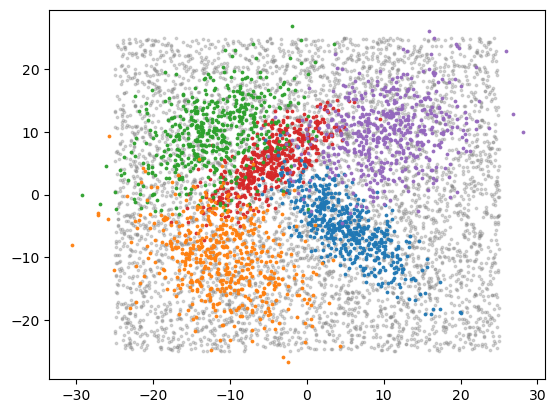

In [4]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'vx', 'vy'
#x_col, y_col = 'vt_ra', 'vt_dec'
#x_col, y_col = 'pmra', 'pmdec'
for idx_sel, alpha, c, zo in zip([idx_cluster_1, idx_cluster_2, idx_cluster_3, idx_cluster_4, idx_cluster_5, idx_bg], alphas, colors, zorders): 
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, c=c, alpha=alpha, zorder=zo)
    
    #scatter more in uvw 

In [5]:
U, V, W = equatorial_UVW(
    ra,
    dec,
    pmra,
    pmdec,
    rv_calc,
    dist,
)
# Check if the transformation is correct
np.allclose(U, df.vx.values, atol=1e-1), np.allclose(V, df.vy.values, atol=1e-1), np.allclose(W, df.vz.values, atol=1e-1)
print(df)
df.to_csv('data.csv', index=False)


              x          y          z         vx         vy         vz  \
0     -6.272994  22.535715  11.599697   4.932924 -17.199068 -17.200274   
1    -22.095819  18.308807   5.055751  10.403629 -23.970775  23.495493   
2     16.622132 -14.383044 -15.908752 -15.829775  -9.787888   1.237822   
3     -3.402749 -10.438543   5.592645 -18.025307 -10.392768  -6.681908   
4     -2.196501  14.258798 -15.016311   0.711722   4.620728 -22.677479   
...         ...        ...        ...        ...        ...        ...   
7495   0.318430   0.648008  14.767137  10.876024 -15.135884 -18.447722   
7496   5.940312  12.321013  16.776978   8.326091 -16.844013 -20.403112   
7497  18.546338  17.914509   9.237268  10.856226 -14.866233 -20.159990   
7498   4.620124  10.868567  16.013856   9.148356 -15.105983 -20.323542   
7499  14.467780   3.492152  17.611243  10.321478 -14.846155 -20.956594   

              ra        dec       dist        pmra       pmdec  \
0     281.680238  74.477071  26.110571   59.7

# Apply TreeSigMA

In [6]:
knn_list=[15, 20, 25, 30]
cluster_features=['x', 'y', 'z']
sigma_kwargs = dict(
        nb_resampling=0,
        max_knn_density=int(np.max(knn_list)+1),
        beta=0.99,
        knn_initcluster_graph=35
    )

# Initialize TreeSigMA
tree = ts.TreeSigMA(
    data=df,
    cluster_features=cluster_features,
    **sigma_kwargs
)

# Run clustering to generate the tree
alpha_values =tree.run()

# Iterate through tree levels
for alpha, labels in tree:
    print(f"Alpha: {alpha}, Labels: {np.unique(labels)}")

# Visualize the clustering tree
#ts.visualize_tree(x_col='x', y_col='y')


Performing gradient ascend using a 20-NN density estimation.
Alpha: 2.7200464103316335e-14, Labels: [5485 5701]
Alpha: 8.358314040890491e-13, Labels: [5485 5701 6473]
Alpha: 7.849489391809072e-10, Labels: [5485 5701 6473 7293]
Alpha: 0.008350465821492625, Labels: [5485 5701 6473 6974 7293]
Alpha: 0.017127265996220276, Labels: [3776 5485 5701 6473 6974 7293]
Alpha: 0.02469809778260229, Labels: [3776 5485 5701 6473 6817 6974 7293]
Alpha: 0.037522411886541485, Labels: [3776 5485 5589 5701 6473 6817 6974 7293]
Alpha: 0.047485295197628785, Labels: [3776 3894 5485 5589 5701 6473 6817 6974 7293]
Alpha: 0.07662375372192809, Labels: [3776 3894 5010 5485 5589 5701 6473 6817 6974 7293]
Alpha: 0.10769685157837228, Labels: [ 427 3776 3894 5010 5485 5589 5701 6473 6817 6974 7293]
Alpha: 0.1279220684767023, Labels: [ 427 3776 3894 5010 5203 5485 5589 5701 6473 6817 6974 7293]
Alpha: 0.1480642055087915, Labels: [ 427 3776 3894 5010 5203 5247 5485 5589 5701 6473 6817 6974 7293]
Alpha: 0.166305418305711

AttributeError: 'TreeSigMA' object has no attribute 'alpha'